In [74]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [2]:
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))
from preprocessing import DataPreprocess

In [3]:
# read prepared df with 60 min frequancy
df = pd.read_csv("df_171022_231222.csv")
df.columns

Index(['Timestamp', '309', '317', '319', '327', '481', 'Qdis', '381', '395',
       '406', '407', '408', '409', '381_c', '395_c'],
      dtype='object')

# The general idea is to predict temperature before HE
## The key parameters to accomplish task are:
* Status of ctfs (enabled/disabled)
* Air temperature
* Month, dat, hour that have concrete correlation with T of air and ctfs operation

## Feature engineering required:
* retrive Month, day and hour values for each row
* use trigonometric transoformation to show explicit cyclic dependencies

In [4]:
# drop 381 and 395 (ctf1 and ctf2) numerical values
# drop all columns that are not going to be used
df_use = df.drop(labels=['309', '319', "381","395", '481', 'Qdis', '406', '407',
           '408', '409'], axis=1)

In [5]:
y = df_use["317"]
X = df_use.drop(["317"], axis=1)
X["Timestamp"] = pd.to_datetime(X["Timestamp"])

In [6]:
X_init = X.copy()

In [7]:
# DataPreprocess instance
dp = DataPreprocess()

In [8]:
# our data is cyclic type
# apply feature engineering to create new columns

X["Hour"] = dp.retrieve_datatime(X["Timestamp"], "hour")
X["Day"] = dp.retrieve_datatime(X["Timestamp"], "day")
X["Month"] = dp.retrieve_datatime(X["Timestamp"], "month")

# drop Timestamp col
X = X.drop("Timestamp", axis=1)

In [9]:
X

,327,381_c,395_c,Hour,Day,Month
0,5.754091,1,1,18,17,10
1,5.632039,1,1,19,17,10
2,5.305963,1,1,20,17,10
3,4.877073,1,1,21,17,10
4,4.478302,1,1,22,17,10
...,...,...,...,...,...,...
537,-21.457674,0,0,10,23,12
538,-20.816818,0,1,11,23,12
539,-20.190611,0,1,12,23,12
540,-20.048624,0,1,13,23,12


<AxesSubplot: >

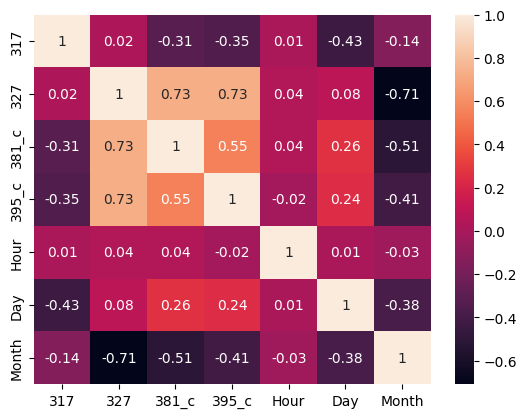

In [443]:
# just quick view on columns correlations without Datetime preprocessing
# the raw month column  provide the worst correletation (obvious)
# ZERO postitve corr but data has not preprocessed yet
sns.heatmap(pd.concat([y,X], axis=1).corr().round(2), annot=True)

In [11]:
# convert m,d,h into dummies
# Hour were dropped as there are no positive correlations with core data
ohe = OneHotEncoder()
dum_col = X.loc[:, ["Month", "Day"]]
ohe_dt = ohe.fit_transform(dum_col).toarray()
ohe_labels = [*ohe.categories_]
# X_dum

In [12]:
# new df with datetime columns which are ohe
df_dt_ohe = pd.DataFrame(ohe_dt, columns=[*ohe_labels[0], *ohe_labels[1]])

In [13]:
# merge with Tair amd ctf cols
df_mer_ohe = pd.concat([X.loc[:, ["327", "381_c", "395_c"]], df_dt_ohe], axis=1)
df_mer_ohe.columns = df_mer_ohe.columns.astype(str)

<AxesSubplot: >

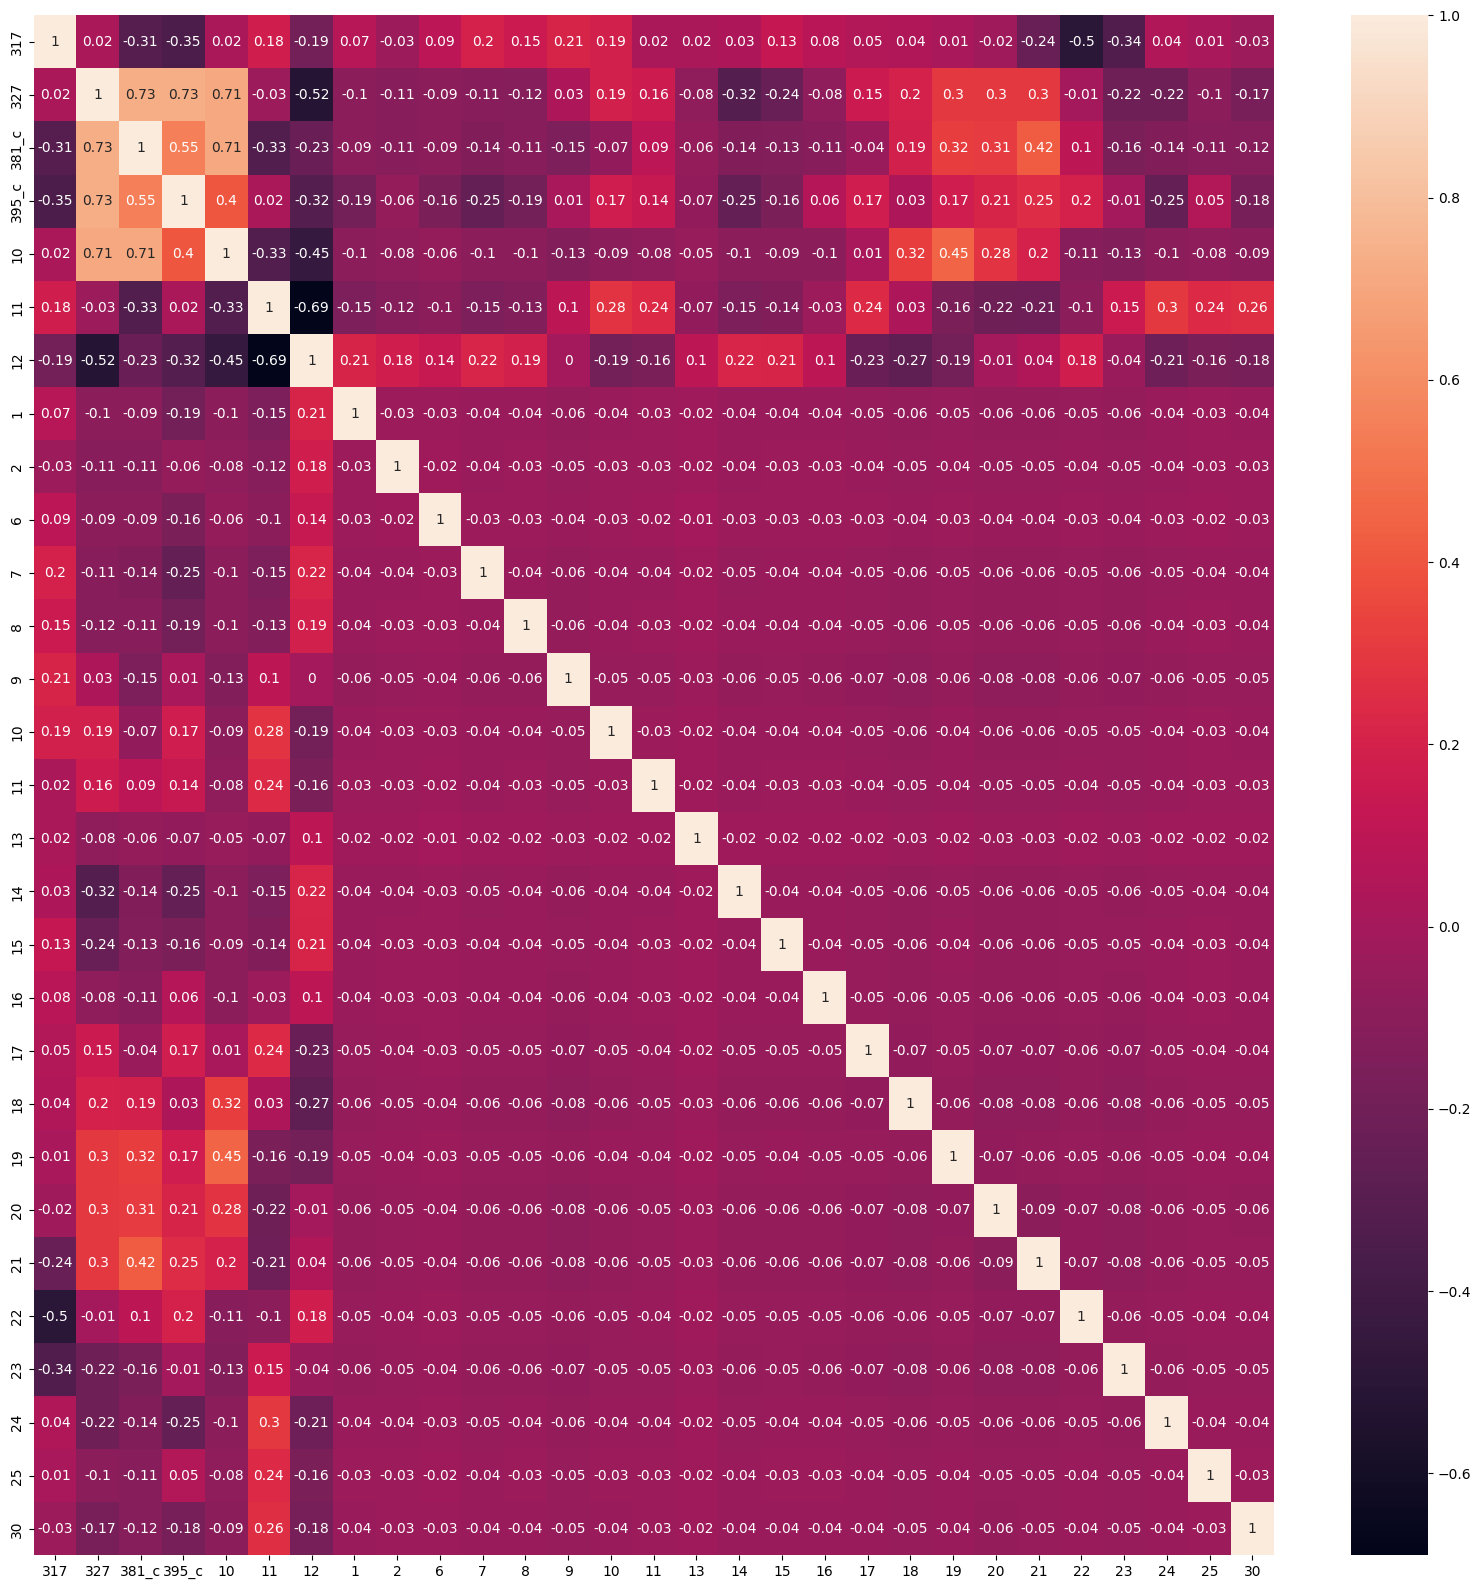

In [446]:
# just quick view on columns correlations with Datetime one hot encoded
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(pd.concat([y, df_mer_ohe], axis=1).corr().round(2), annot=True, ax=ax)
# plt.savefig("hm.png")

# ZERO positive correlations on heatmap
## But gonna try different Kfold split to check if it's ok to train on

In [15]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor

ts_cv = TimeSeriesSplit(
    n_splits=4,
    gap=200,
    max_train_size=160,
    test_size=70,
)

In [16]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [17]:
ct1 = ColumnTransformer(
        [
            ("norm", Normalizer(), ["327"]),
            ("onehot", OneHotEncoder(sparse_output=True),
                 ["Hour", "Day", "Month"])
        ],  remainder="passthrough")
X_tr = ct1.fit_transform(X).toarray()
X_tr

array([[ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       ...,
       [-1.,  0.,  0., ...,  1.,  0.,  1.],
       [-1.,  0.,  0., ...,  1.,  0.,  1.],
       [-1.,  0.,  0., ...,  1.,  0.,  1.]])

In [18]:
splits_1 = list(ts_cv.split(X_tr, y))
# splits_1

In [19]:
# GradientBoostingRegressor chosen as nonlinear model to train
gbr = GradientBoostingRegressor()

In [20]:
# 2 evaluations: one where hour, day and month are used as ohe data
# other uses only month and day as oge data
evaluate(gbr, X_tr, y, ts_cv), evaluate(gbr, df_mer_ohe, y, ts_cv)

Mean Absolute Error:     2.579 +/- 1.749
Root Mean Squared Error: 2.923 +/- 1.991
Mean Absolute Error:     2.579 +/- 1.778
Root Mean Squared Error: 2.983 +/- 1.849


(None, None)

# all data bellow must be rewritten into more consistent style

In [21]:
for tr, te in splits_1:
    gbr.fit(X_tr[tr], y.iloc[tr])

In [22]:
gbr_score_1 = []
for tr, te in splits_1:
    gbr_score_1.append(gbr.score(X_tr[tr], y.iloc[tr]))

In [23]:
gbr_te_1 = []
for tr, te in splits_1:
    gbr_te_1.append(gbr.predict(X_tr[te]))

In [24]:
gbr_tr_1 = []
for tr, te in splits_1:
    gbr_tr_1.append(gbr.predict(X_tr[tr]))

In [25]:
import matplotlib.pyplot as plt

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

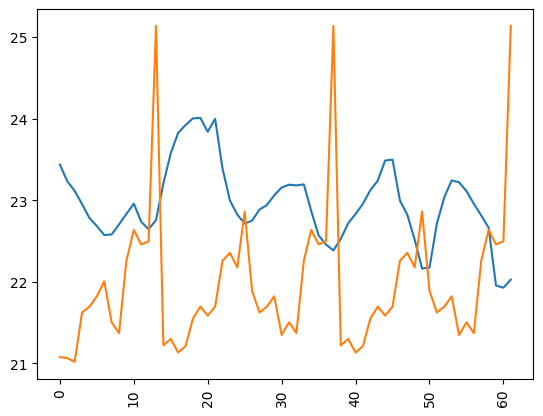

In [26]:
# prediction on train data and origin label
# 0st train set
ind = 0
plt.plot(X.index[splits_1[ind][0]], y[splits_1[ind][0]])
plt.plot(X.index[splits_1[ind][0]], gbr_tr_1[ind])
plt.xticks(rotation=90)

(array([250., 260., 270., 280., 290., 300., 310., 320., 330., 340.]),
 [Text(250.0, 0, '250'),
  Text(260.0, 0, '260'),
  Text(270.0, 0, '270'),
  Text(280.0, 0, '280'),
  Text(290.0, 0, '290'),
  Text(300.0, 0, '300'),
  Text(310.0, 0, '310'),
  Text(320.0, 0, '320'),
  Text(330.0, 0, '330'),
  Text(340.0, 0, '340')])

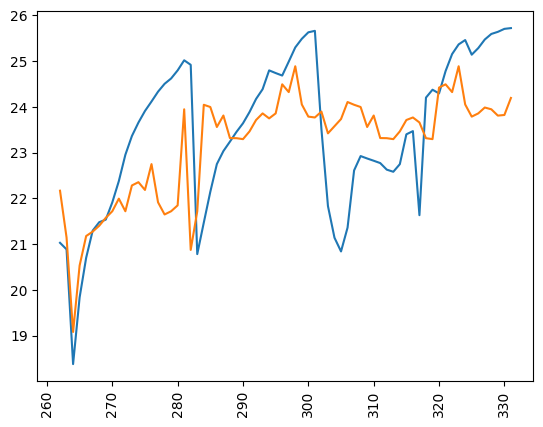

In [27]:
# prediction on train data and origin label
# 0st test set
ind = 0
plt.plot(X.index[splits_1[ind][1]], y[splits_1[ind][1]])
plt.plot(X.index[splits_1[ind][1]], gbr_te_1[ind])
plt.xticks(rotation=90)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120'),
  Text(140.0, 0, '140')])

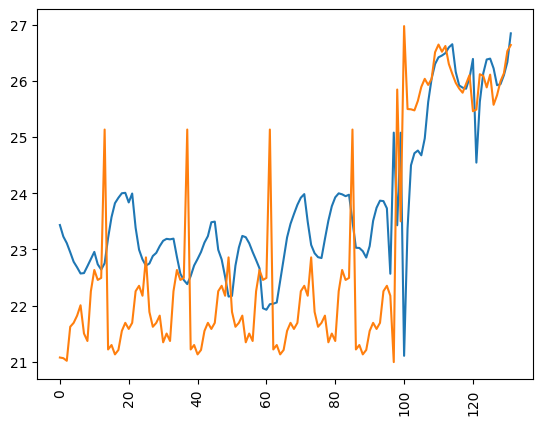

In [28]:
# prediction on train data and origin label
# 1st train set
ind = 1
plt.plot(X.index[splits_1[ind][0]], y[splits_1[ind][0]])
plt.plot(X.index[splits_1[ind][0]], gbr_tr_1[ind])
plt.xticks(rotation=90)

(array([320., 330., 340., 350., 360., 370., 380., 390., 400., 410.]),
 [Text(320.0, 0, '320'),
  Text(330.0, 0, '330'),
  Text(340.0, 0, '340'),
  Text(350.0, 0, '350'),
  Text(360.0, 0, '360'),
  Text(370.0, 0, '370'),
  Text(380.0, 0, '380'),
  Text(390.0, 0, '390'),
  Text(400.0, 0, '400'),
  Text(410.0, 0, '410')])

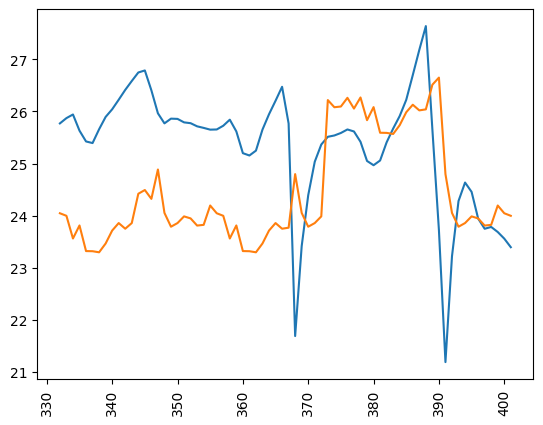

In [29]:
# prediction on train data and origin label
# 1st test set
ind = 1
plt.plot(X.index[splits_1[ind][1]], y[splits_1[ind][1]])
plt.plot(X.index[splits_1[ind][1]], gbr_te_1[ind])
plt.xticks(rotation=90)

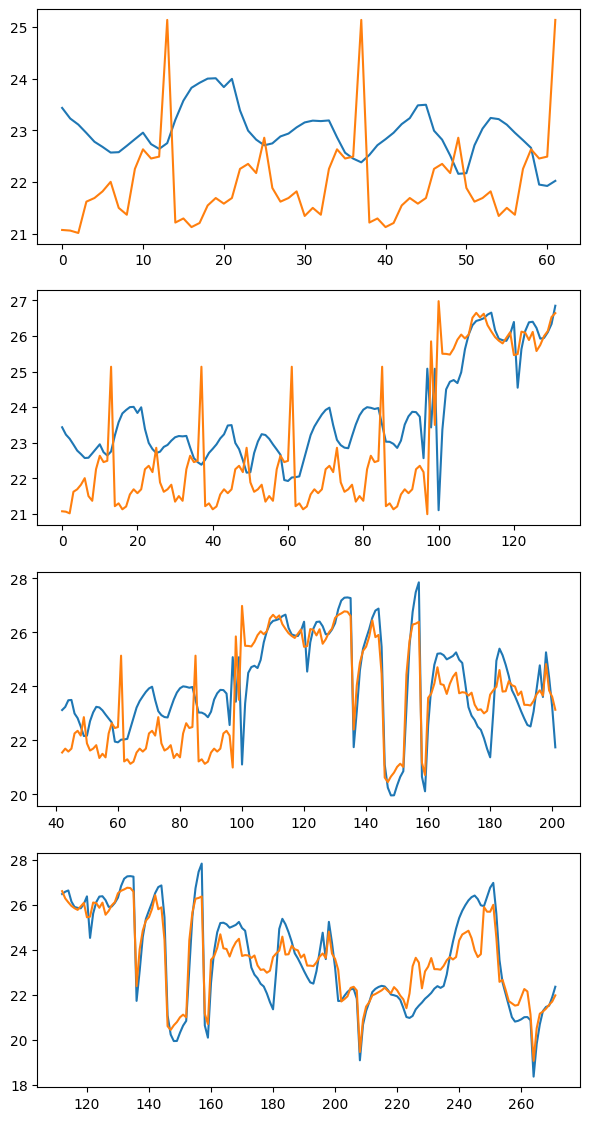

In [30]:
# lets plot all data together
#train and origin
fig, axs = plt.subplots(4,1, figsize=(7,14))
axs[0].plot(X.index[splits_1[0][0]], y[splits_1[0][0]])
axs[0].plot(X.index[splits_1[0][0]], gbr_tr_1[0])

axs[1].plot(X.index[splits_1[1][0]], y[splits_1[1][0]])
axs[1].plot(X.index[splits_1[1][0]], gbr_tr_1[1])

axs[2].plot(X.index[splits_1[2][0]], y[splits_1[2][0]])
axs[2].plot(X.index[splits_1[2][0]], gbr_tr_1[2])

axs[3].plot(X.index[splits_1[3][0]], y[splits_1[3][0]])
axs[3].plot(X.index[splits_1[3][0]], gbr_tr_1[3])

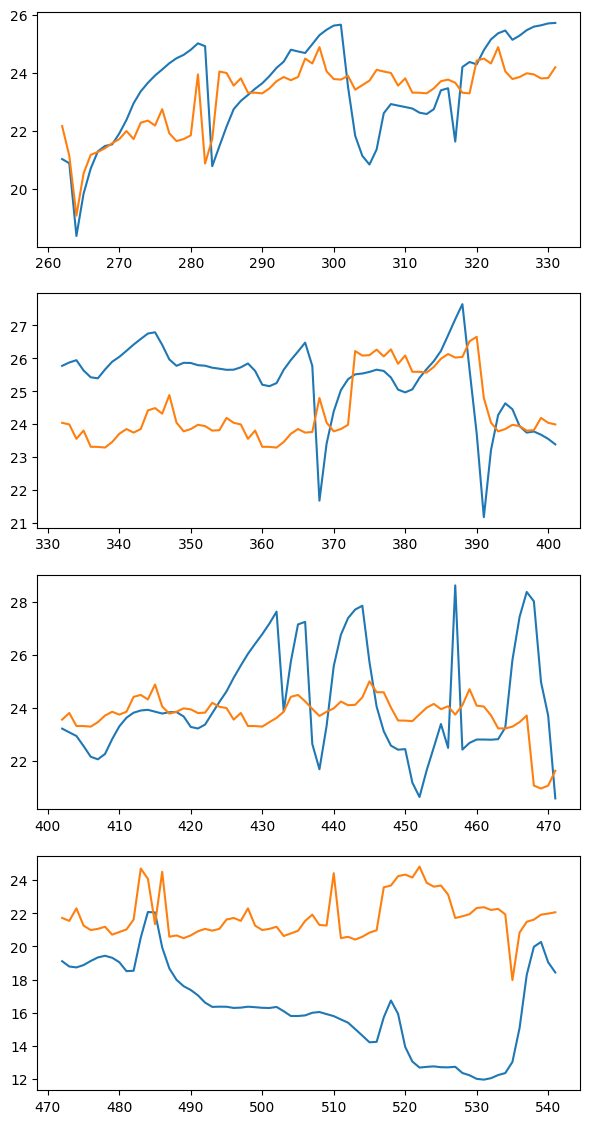

In [31]:
# fit and origin label
#train and origin
fig, axs = plt.subplots(4,1, figsize=(7,14))
axs[0].plot(X.index[splits_1[0][1]], y[splits_1[0][1]])
axs[0].plot(X.index[splits_1[0][1]], gbr_te_1[0])

axs[1].plot(X.index[splits_1[1][1]], y[splits_1[1][1]])
axs[1].plot(X.index[splits_1[1][1]], gbr_te_1[1])

axs[2].plot(X.index[splits_1[2][1]], y[splits_1[2][1]])
axs[2].plot(X.index[splits_1[2][1]], gbr_te_1[2])

axs[3].plot(X.index[splits_1[3][1]], y[splits_1[3][1]])
axs[3].plot(X.index[splits_1[3][1]], gbr_te_1[3])

# From quick trainings and tests made:
* Time sieries split is not suitable case to split dataset cuz it randomly chooses data from dataset which cause to merge weeks together (last point from one week with first point of next week) that is why we do see straight line on plot. This all leads to misunderstanding and confusing
* Use default kfolds to split on n folds

## GradientBoostRegressor was used by sklearn recommendation for timeseries datasets
### However in our case it is not  time dependent because we do try to find correletation between parameters that are always in our dataset no matter what time is (will matter if we take the whole year). 
### There are different effects depends on what month or day (seasonal effects) only

In [268]:
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.neural_network import MLPRegressor

In [269]:
models_list = ["KNeighbors_distance", "GPR", "MLP", "GBR", "SGDR"]
models = [KNeighborsRegressor(weights = 'distance'),
          GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel()),
          MLPRegressor(batch_size=32, hidden_layer_sizes=100, max_iter=500, random_state=42),
          GradientBoostingRegressor(),
          SGDRegressor(max_iter=1000)
         ]

In [270]:
# try basic KFold cv
kf_cv = KFold(
    n_splits=4,
    random_state=None,
    shuffle=False,
)

In [271]:
from model import TrainModel
X_ohe_norm = df_mer_ohe.copy()
X_ohe_minmax = df_mer_ohe.copy()

In [272]:
#Norm
norm_327 = Normalizer().fit(X_ohe_norm["327"].to_numpy().reshape(-1,1))
X_ohe_norm["327"] = norm_327.transform(X_ohe_norm["327"].to_numpy().reshape(-1,1)).reshape(-1)
# X_ohe_norm["327"].to_numpy().reshape(-1,1)

In [273]:
# #MinMax
minmax_327 = MinMaxScaler().fit(X_ohe_minmax["327"].to_numpy().reshape(-1,1))
X_ohe_minmax["327"] = minmax_327.transform(X_ohe_minmax["327"].to_numpy().reshape(-1,1)).reshape(-1)

In [274]:
X_ohe_norm["327"].mean(), X_ohe_minmax["327"].mean()

(-0.6125461254612546, 0.48134310016970216)

In [275]:
tm = TrainModel(X_ohe_norm, y)

## Evaluation results for different models and basic Kfold split

In [276]:
tm.model_comparison(models_list, models, kf_cv)

Evaluating of KNeighbors_distance
Mean Absolute Error:     2.568 +/- 1.076
Root Mean Squared Error: 3.074 +/- 1.454

Evaluating of GPR
Mean Absolute Error:     2.608 +/- 0.554
Root Mean Squared Error: 3.173 +/- 0.836

Evaluating of MLP
Mean Absolute Error:     5.753 +/- 1.996
Root Mean Squared Error: 6.602 +/- 2.031

Evaluating of GBR
Mean Absolute Error:     2.563 +/- 1.177
Root Mean Squared Error: 3.159 +/- 1.476

Evaluating of SGDR
Mean Absolute Error:     5.136 +/- 2.700
Root Mean Squared Error: 5.903 +/- 2.981



In [277]:
tm = TrainModel(X_ohe_minmax, y)

In [278]:
tm.model_comparison(models_list, models, kf_cv)

Evaluating of KNeighbors_distance
Mean Absolute Error:     2.834 +/- 0.944
Root Mean Squared Error: 3.810 +/- 1.023

Evaluating of GPR
Mean Absolute Error:     2.544 +/- 0.847
Root Mean Squared Error: 3.100 +/- 1.134

Evaluating of MLP


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error:     5.784 +/- 0.389
Root Mean Squared Error: 6.482 +/- 0.412

Evaluating of GBR
Mean Absolute Error:     2.871 +/- 1.132
Root Mean Squared Error: 3.475 +/- 1.344

Evaluating of SGDR
Mean Absolute Error:     4.321 +/- 1.745
Root Mean Squared Error: 5.030 +/- 1.891



In [258]:
folds = list(kf_cv.split(X_ohe_minmax))
fold_1 = folds[0]
fold_1[0]

array([136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 31

Score: 0.7679199845712524
Score: -1.7382943924294278
Score: 0.8182016923688055
Score: -0.3777428808233416
Score: 0.7439948564063135
Score: -2.0947300191957625
Score: 0.6576572515041119
Score: -0.19030504508590806


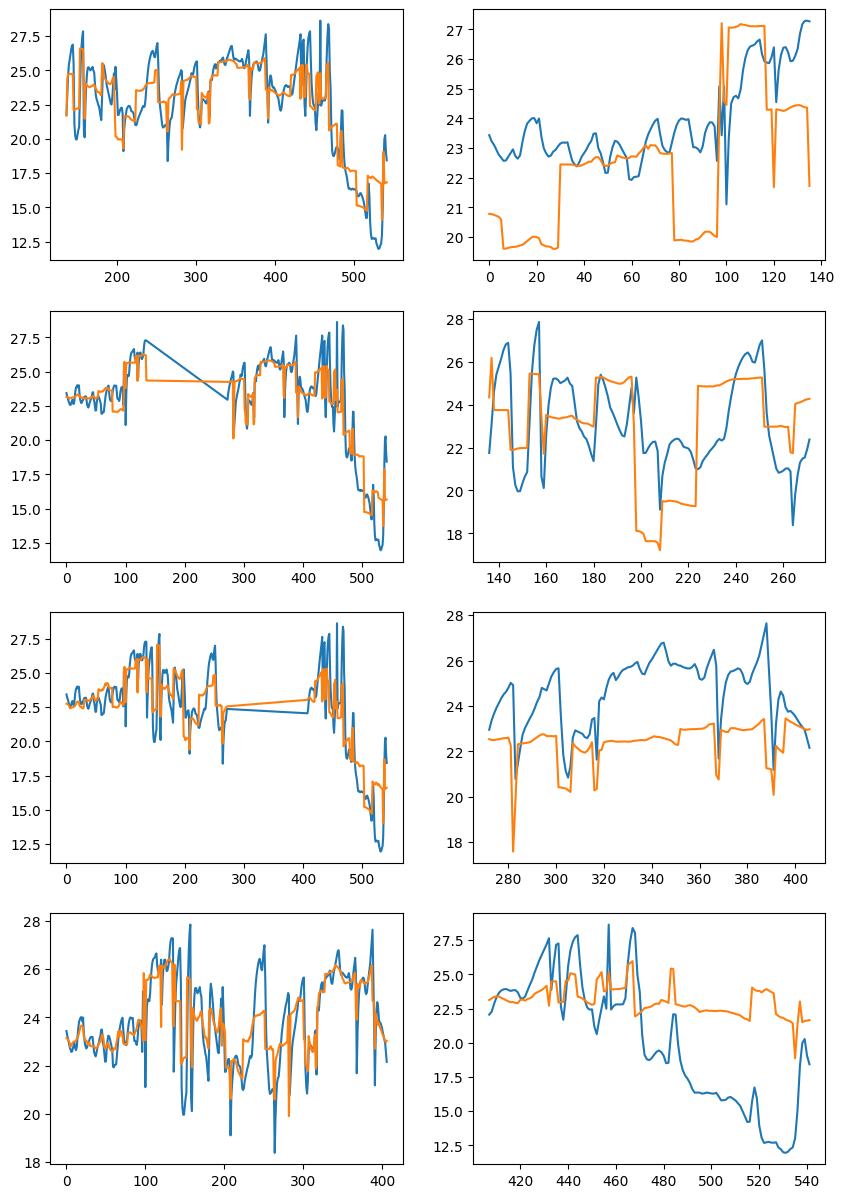

In [265]:
# GPR visualization
fig, axss = plt.subplots(len(folds), 2, figsize=(10,15))
model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel())
for axs, ds in zip(axss, folds):
    # train model
    model = model.fit(X_ohe_minmax.iloc[ds[0]], y.iloc[ds[0]])
    for i in range(len(axs)):
        print(f"Score: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))
    

Score: 0.9106489399956953
Score: -6.039916066805324
Score: 0.9226562367254589
Score: -1.2878917492695976
Score: 0.9202600186065183
Score: -0.32125235743638036
Score: 0.8762975247093963
Score: -0.36903655062088303


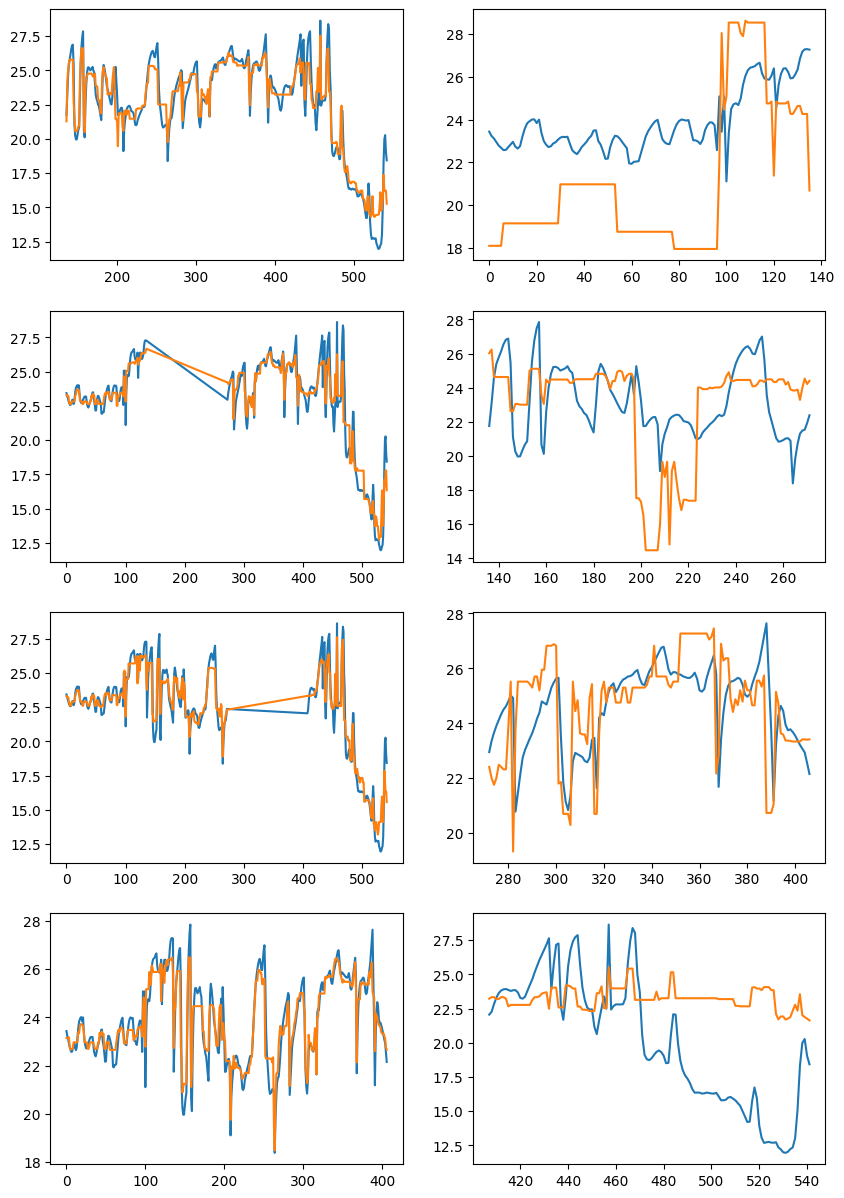

In [266]:
# GBR visualization
fig, axss = plt.subplots(len(folds), 2, figsize=(10,15))
model = GradientBoostingRegressor()
for axs, ds in zip(axss, folds):
    # train model
    model = model.fit(X_ohe_minmax.iloc[ds[0]], y.iloc[ds[0]])
    for i in range(len(axs)):
        print(f"Score: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))

Score: 0.9106489399956953
Score: -6.448927837417145
Score: 0.9226562367254589
Score: -1.2878917492695976
Score: 0.9202600186065182
Score: -0.31642007917838
Score: 0.8762975247093963
Score: -0.37503026272584794


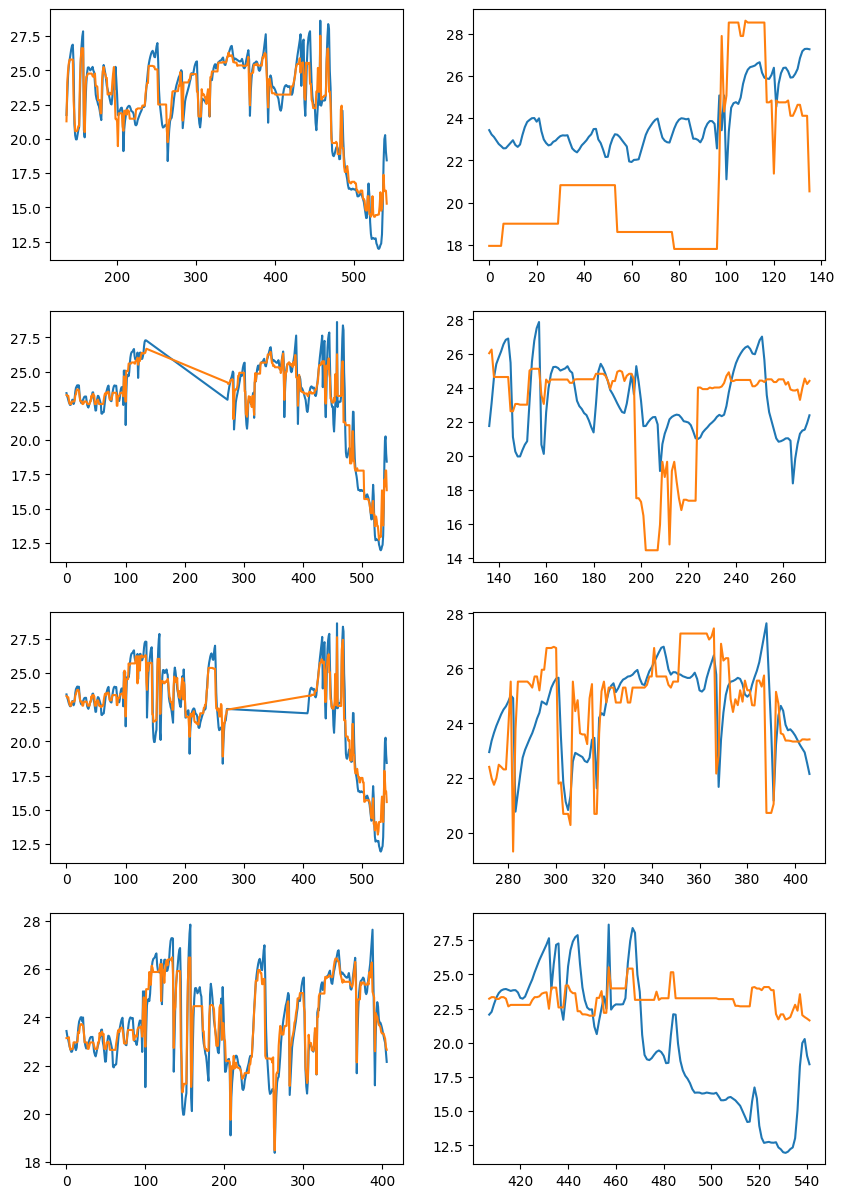

In [267]:
# GBR visualization
fig, axss = plt.subplots(len(folds), 2, figsize=(10,15))

for axs, ds in zip(axss, folds):
    # train model
    model = GradientBoostingRegressor()
    model = model.fit(X_ohe_minmax.iloc[ds[0]], y.iloc[ds[0]])
    for i in range(len(axs)):
        print(f"Score: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))

## Providing as dynamic as possible training data gives us pretty logical test results for both  models. In this way model can recognise Tair, ctfs changes

# Good results by prediction caused by training of whole dataset --> data is not unseen

Score train: 0.8606115465553523
Score test: 0.8298672164657555
Score train: 0.869048225969976
Score test: 0.8066089611929352
Score train: 0.9202600186065182
Score test: -0.32491171858172163
Score train: 0.5766401194021842
Score test: 0.9220255954424847


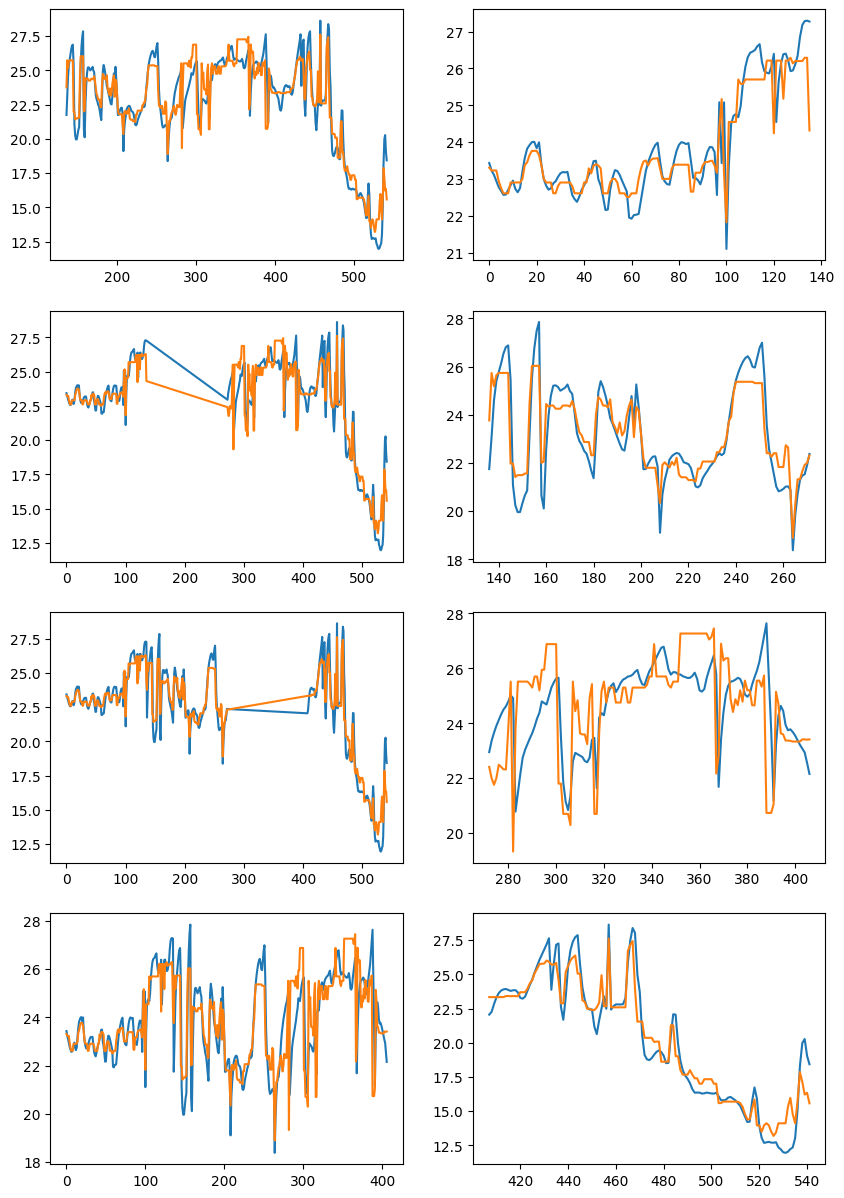

In [280]:
# Take fold_3 to test in on other test folds
# For some folds score is more than 90%
fold_3 = folds[2]

fig, axss = plt.subplots(len(folds), 2, figsize=(10,15))

# train model only on fold_3 training data
model = GradientBoostingRegressor()
model = model.fit(X_ohe_minmax.iloc[fold_3[0]], y.iloc[fold_3[0]])
for axs, ds in zip(axss, folds):
    for i in range(len(axs)):
        if i % 2 == 0:
            print(f"Score train: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        else:
            print(f"Score test: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))

In [281]:
# try grid search to improve model preiction on dynamic data
# main parameters to tune: lr, n_estimators, max_depth
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [331]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(GradientBoostingRegressor(), 
                     {
                         "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1],
                         "max_depth": [1, 2, 4, 8, 10, 12, 14],
                         "n_estimators": [32, 64, 128, 256, 512, 1024]
                     },
                     scoring="neg_mean_absolute_error")

In [332]:
search.fit(X_ohe_minmax.iloc[fold_3[0]], y.iloc[fold_3[0]])

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
                         'max_depth': [1, 2, 4, 8, 10, 12, 14],
                         'n_estimators': [32, 64, 128, 256, 512, 1024]},
             scoring='neg_mean_absolute_error')

In [334]:
search.best_params_

{'learning_rate': 0.001, 'max_depth': 12, 'n_estimators': 512}

Score train: 0.6141071989573181
Score test: 0.21749843565299687
Score train: 0.6087089140262962
Score test: 0.5654840613409591
Score train: 0.6317317404200463
Score test: -0.5147618630130051
Score train: 0.2921669211970853
Score test: 0.5504051144246576


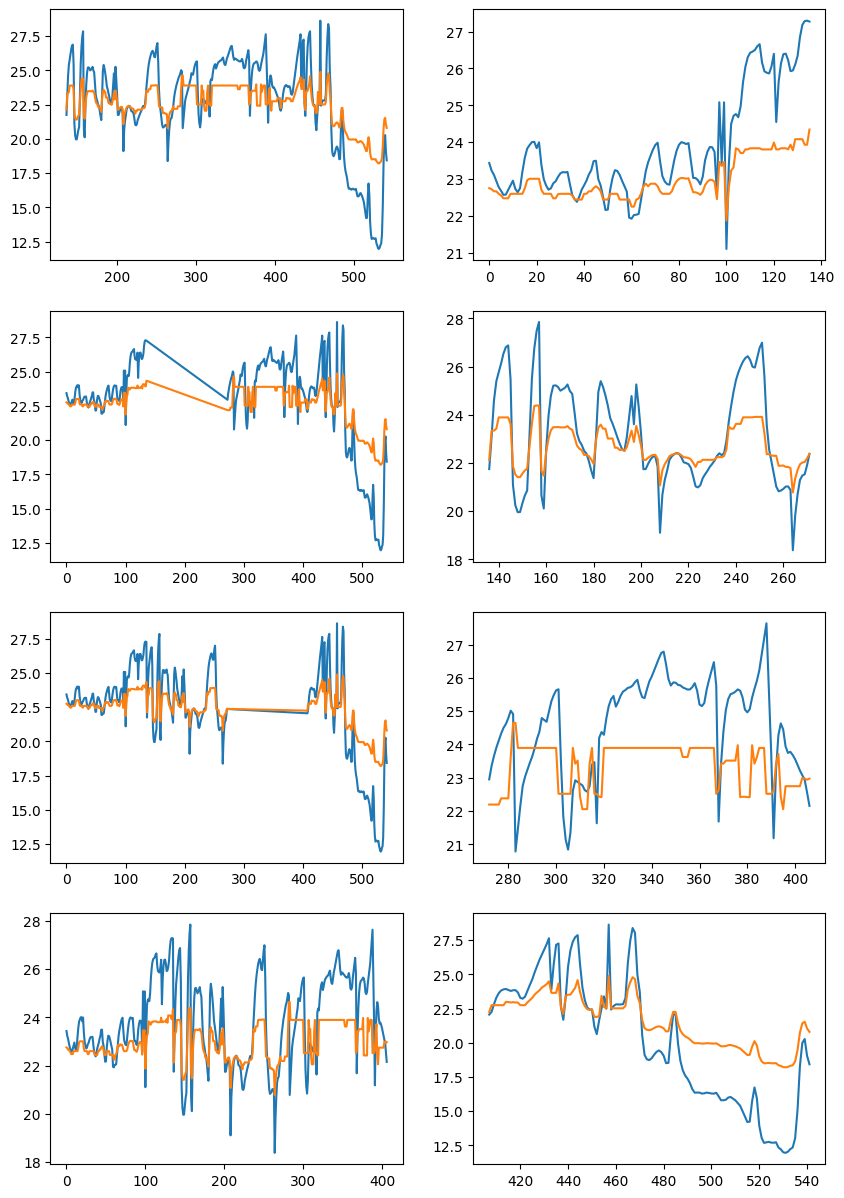

In [335]:
# lets apply best params and test on dataset with folds
# Take fold_3 to test in on other test folds
# < Search grid makes all worse >
fold_3 = folds[2]

fig, axss = plt.subplots(len(folds), 2, figsize=(10,15))

# train model only on fold_3 training data
model = GradientBoostingRegressor(**search.best_params_)
model = model.fit(X_ohe_minmax.iloc[fold_3[0]], y.iloc[fold_3[0]])
for axs, ds in zip(axss, folds):
    for i in range(len(axs)):
        if i % 2 == 0:
            print(f"Score train: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        else:
            print(f"Score test: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))

Score train: 0.9381690355133756
Score test: 0.941749328586425
Score train: 0.9375048634614577
Score test: 0.9618929913825004
Score train: 0.9857005127786691
Score test: 0.07823730412804619
Score train: 0.7614081923514397
Score test: 0.9893587887564298


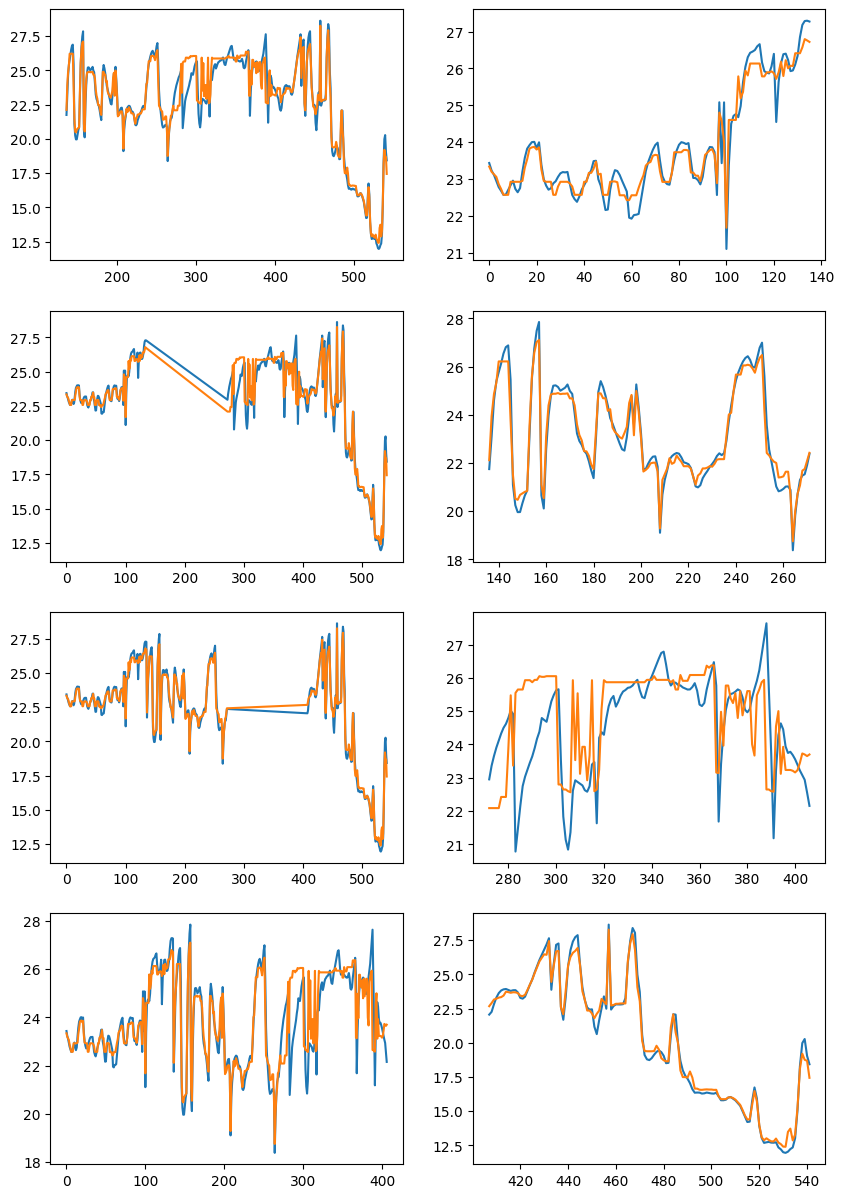

In [320]:
# lets try some manual param search
# Take fold_3 to test in on other test folds
# max_depth significantly improve prediction of each fold

fold_3 = folds[2]
fig, axss = plt.subplots(len(folds), 2, figsize=(10,15))

# train model only on fold_3 training data
model = GradientBoostingRegressor(n_estimators=64, max_depth=6)
model = model.fit(X_ohe_minmax.iloc[fold_3[0]], y.iloc[fold_3[0]])
for axs, ds in zip(axss, folds):
    for i in range(len(axs)):
        if i % 2 == 0:
            print(f"Score train: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        else:
            print(f"Score test: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))

In [337]:
kf_cv_8 = KFold(n_splits=8)
folds_8 = list(kf_cv_8.split(X_ohe_minmax))

Score train: 0.940465616742552
Score test: 0.7155499807305504
Score train: 0.9372580451180813
Score test: 0.9215292201787912
Score train: 0.9385845525617836
Score test: 0.9547156422906841
Score train: 0.9385315763086963
Score test: 0.9631609038810668
Score train: 0.9728957205659337
Score test: -0.4160460720538137
Score train: 0.9491703353686708
Score test: 0.39720800335554773
Score train: 0.9374441165423326
Score test: 0.9574657480296248
Score train: 0.8030888433167864
Score test: 0.9654684145668856


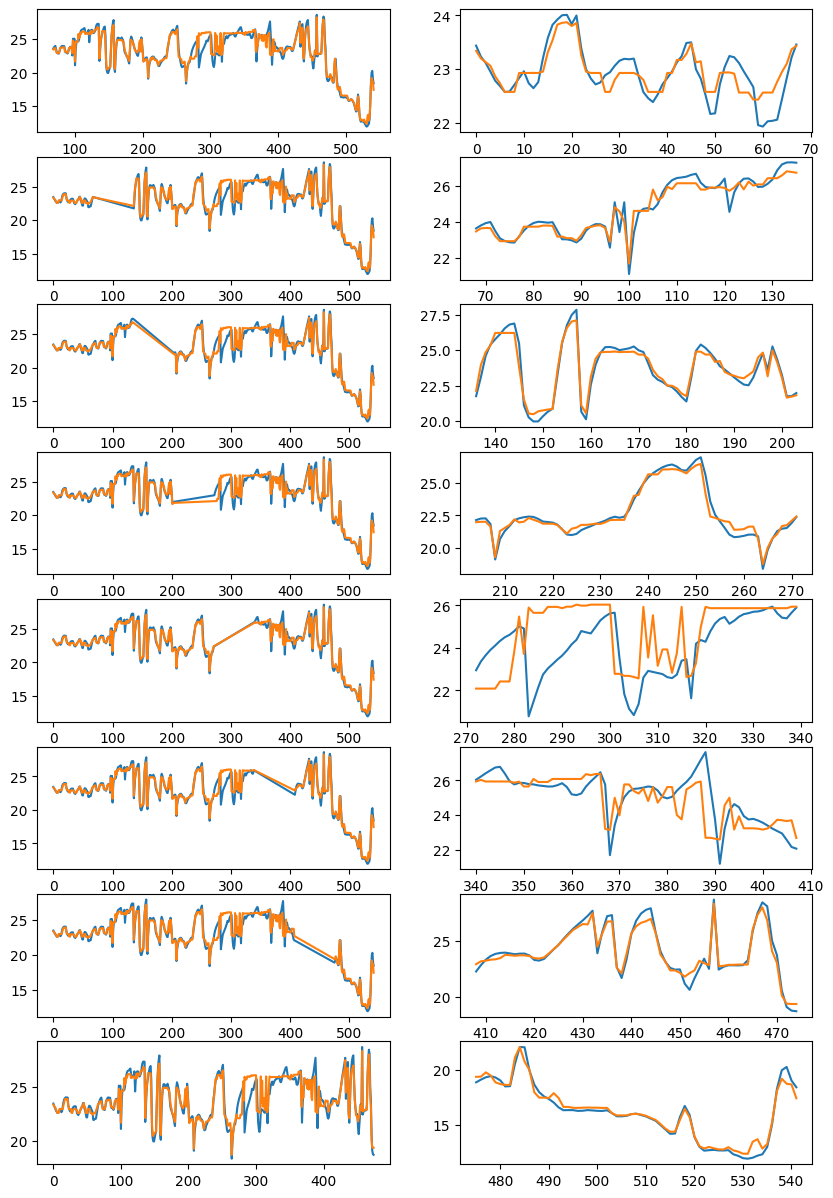

In [338]:
# lets make tests to check if our model works well with unseen data
# Take fold_3 to test in on other test folds
# Taken new kf_cv with n_splits=8 to use as new unseen data
# SOlid result

fold_3 = folds[2]
fig, axss = plt.subplots(len(folds_8), 2, figsize=(10,15))

# train model only on fold_3 training data
model = GradientBoostingRegressor(n_estimators=64, max_depth=6)
model = model.fit(X_ohe_minmax.iloc[fold_3[0]], y.iloc[fold_3[0]])
for axs, ds in zip(axss, folds_8):
    for i in range(len(axs)):
        if i % 2 == 0:
            print(f"Score train: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        else:
            print(f"Score test: {model.score(X_ohe_minmax.iloc[ds[i]], y.iloc[ds[i]])}")
        axs[i].plot(ds[i], y.iloc[ds[i]])
        axs[i].plot(ds[i], model.predict(X_ohe_minmax.iloc[ds[i]]))

## In my opinion to test model on unseen data increasing of training set is required
## On a given dataset there are many different temperature conditions that is way model is confused by rapid temperature raising or drop

# One good way is to try to refactor .csv by making time step equal to 30 min instead of 60 min.

# Another must try is to transform day, hour, month to sin/cos functions, because during one hot encoding "Hour" column was dropped due to having zero positive corelletions with rest of data

In [429]:
XX = df_use.drop(labels=["317"], axis=1)
yy = df_use["317"]

In [430]:
XX["Timestamp"] = pd.to_datetime(XX["Timestamp"])

In [431]:
# retrieve Month, Day, Hour
XX["Month"] = dp.retrieve_datatime(XX["Timestamp"], "month")
XX["Day"] = dp.retrieve_datatime(XX["Timestamp"], "day")
XX["Hour"] = dp.retrieve_datatime(XX["Timestamp"], "hour")

In [432]:
XX

,Timestamp,327,381_c,395_c,Month,Day,Hour
0,2022-10-17 18:00:00,5.754091,1,1,10,17,18
1,2022-10-17 19:00:00,5.632039,1,1,10,17,19
2,2022-10-17 20:00:00,5.305963,1,1,10,17,20
3,2022-10-17 21:00:00,4.877073,1,1,10,17,21
4,2022-10-17 22:00:00,4.478302,1,1,10,17,22
...,...,...,...,...,...,...,...
537,2022-12-23 10:00:00,-21.457674,0,0,12,23,10
538,2022-12-23 11:00:00,-20.816818,0,1,12,23,11
539,2022-12-23 12:00:00,-20.190611,0,1,12,23,12
540,2022-12-23 13:00:00,-20.048624,0,1,12,23,13


In [433]:
# Month column consist of 3 unique values only so keep it by ohe
# Day and Hour cols encodes to sin/cos
# RAW transform
XX["Hour_sin"] = np.sin(2*np.pi*XX["Hour"]/24)
XX["Hour_cos"] = np.cos(2*np.pi*XX["Hour"]/24)
XX

,Timestamp,327,381_c,395_c,Month,Day,Hour,Hour_sin,Hour_cos
0,2022-10-17 18:00:00,5.754091,1,1,10,17,18,-1.000000e+00,-1.836970e-16
1,2022-10-17 19:00:00,5.632039,1,1,10,17,19,-9.659258e-01,2.588190e-01
2,2022-10-17 20:00:00,5.305963,1,1,10,17,20,-8.660254e-01,5.000000e-01
3,2022-10-17 21:00:00,4.877073,1,1,10,17,21,-7.071068e-01,7.071068e-01
4,2022-10-17 22:00:00,4.478302,1,1,10,17,22,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...,...,...,...
537,2022-12-23 10:00:00,-21.457674,0,0,12,23,10,5.000000e-01,-8.660254e-01
538,2022-12-23 11:00:00,-20.816818,0,1,12,23,11,2.588190e-01,-9.659258e-01
539,2022-12-23 12:00:00,-20.190611,0,1,12,23,12,1.224647e-16,-1.000000e+00
540,2022-12-23 13:00:00,-20.048624,0,1,12,23,13,-2.588190e-01,-9.659258e-01


In [434]:
XX = pd.concat([XX.loc[:, ["327", "381_c", "395_c", "Hour_sin", "Hour_cos"]], df_dt_ohe], axis=1)

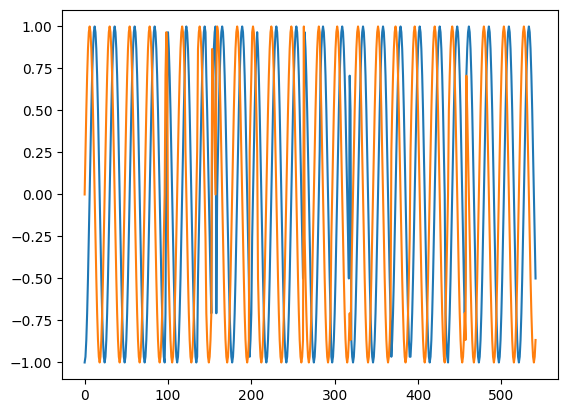

In [435]:
# just quick view on dataset
plt.plot(XX["Hour_sin"])
plt.plot(XX["Hour_cos"])

<AxesSubplot: >

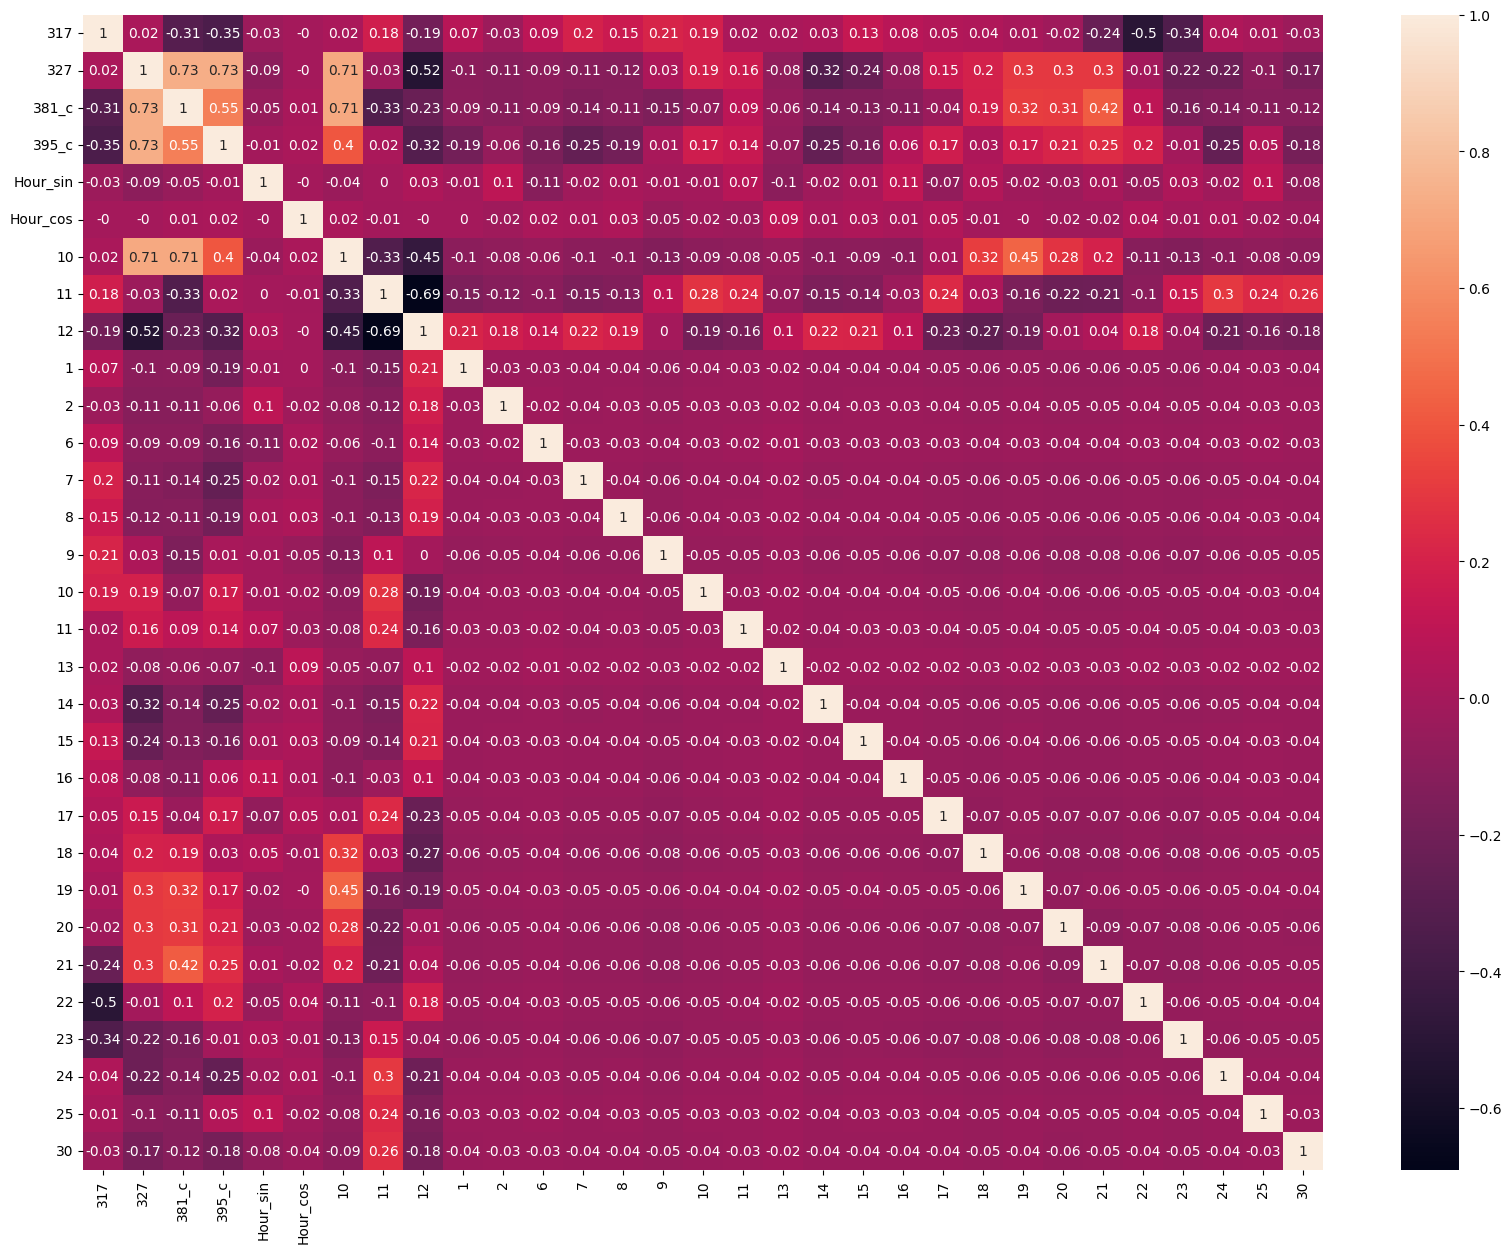

In [441]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(pd.concat([yy, XX], axis=1).corr().round(2), annot=True)

# ZERO positive correleations between df key parameters (ctfs, Tair) and label